# CNN Cancer Detection Kaggle Mini-Project

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import sklearn
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D
from tensorflow.keras.layers import Dropout, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm_notebook, trange
from glob import glob

## Brief description of the problem and data

According to the Kaggle Competition explanation, the goal of this project is to create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. This is a binary classification problem which focuses on dividing 96x96px images into two classes.(https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview) <br> <br>
The dataset provides a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the basic information for the images in the train folder. While predicting the labels for the images in the test folder, a positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region does not influence the label. According to the description in the competition, the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark.

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [2]:
os.listdir("../input/histopathologic-cancer-detection")

['sample_submission.csv', 'train_labels.csv', 'test', 'train']

In [3]:
print(f' There are {len(os.listdir("../input/histopathologic-cancer-detection/train"))} pictures in train.')
print(f' There are {len(os.listdir("../input/histopathologic-cancer-detection/test"))} pictures in test.')

 There are 220025 pictures in train.
 There are 57458 pictures in test.


In [4]:
df = pd.DataFrame({'path': glob(os.path.join("../input/histopathologic-cancer-detection/train",'*.tif'))})
df['id'] = df.path.map(lambda x: x.split('/')[4].split(".")[0])
labels = pd.read_csv("../input/histopathologic-cancer-detection/train_labels.csv")
df = df.merge(labels, on='id')
df.head()

,path,id,label
0,../input/histopathologic-cancer-detection/trai...,d43c081bafa286f9c1f7e921883f26ceafebc912,1
1,../input/histopathologic-cancer-detection/trai...,092d0eedebce504847715ee046b6ad74b57599b4,0
2,../input/histopathologic-cancer-detection/trai...,b0d2582c6218a8764323fc940b41312282b99bf4,0
3,../input/histopathologic-cancer-detection/trai...,187c99df762f13f99818e5593d4bab4c6577e7e3,1
4,../input/histopathologic-cancer-detection/trai...,7c5270c83837de5a5cbb2dca511559dc39d19d53,1


In [5]:
df['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

<Axes: xlabel='label'>

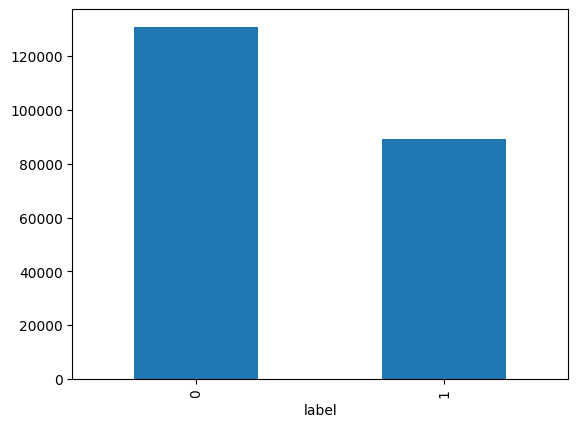

In [6]:
df['label'].value_counts().plot(kind='bar')

### Visualize Sample Images from the Dataset

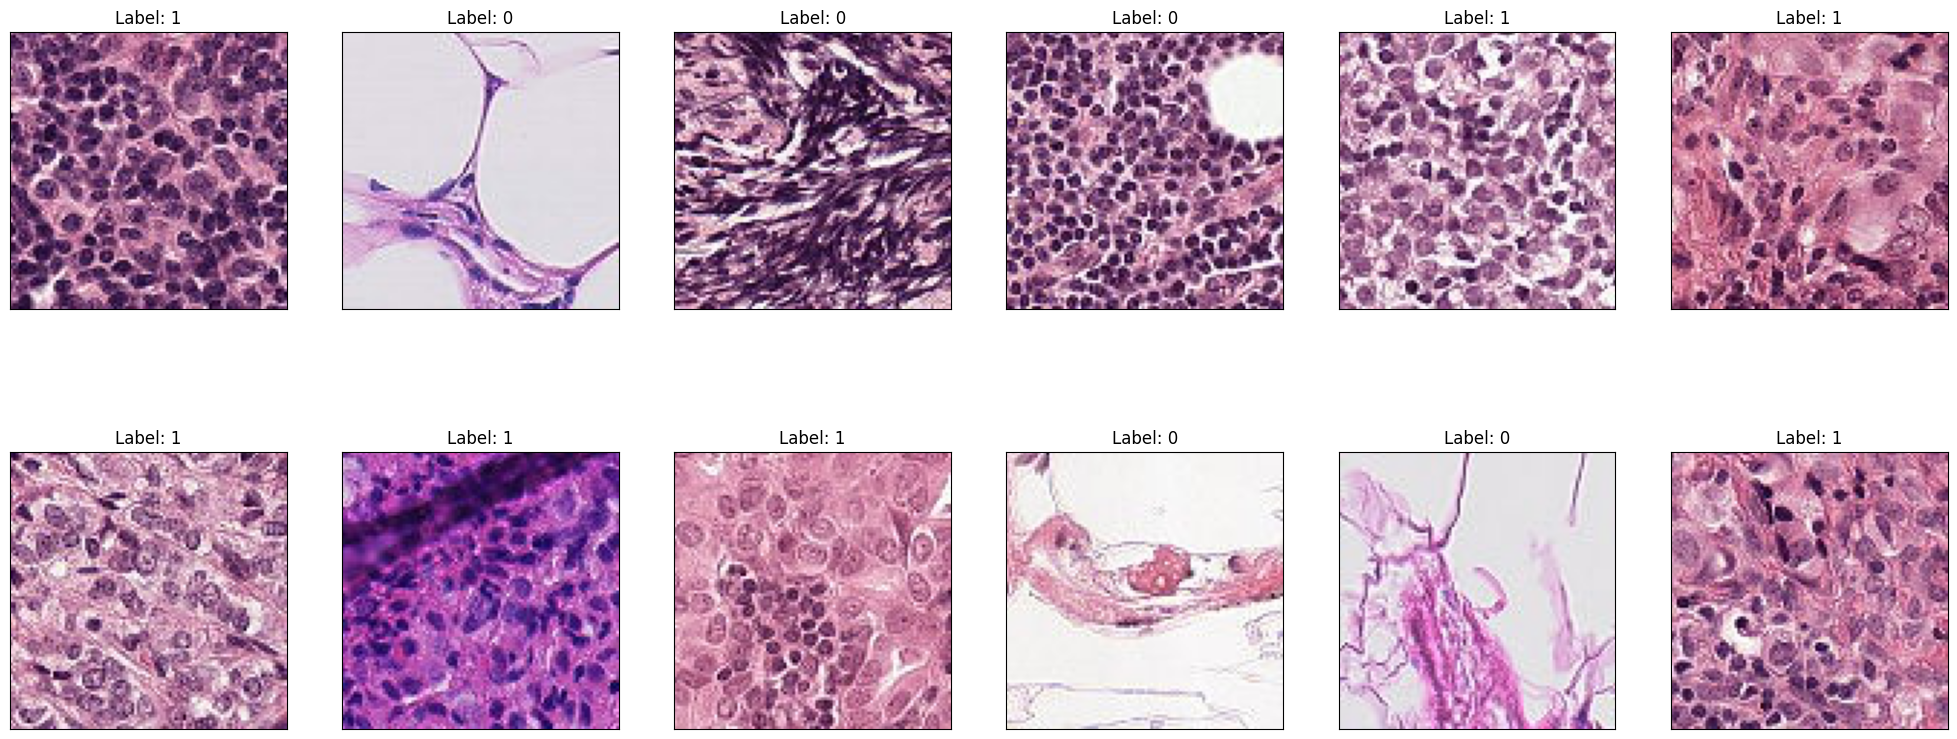

In [7]:
fig = plt.figure(figsize=(25,10))

train_img = os.listdir("../input/histopathologic-cancer-detection/train")

for idx, img in enumerate(np.random.choice(train_img, 12)):
    ax = fig.add_subplot(2, 12//2, idx+1, xticks=[], yticks=[])
    im = Image.open("../input/histopathologic-cancer-detection/train/" + img)
    plt.imshow(im)
    lab = labels.loc[labels['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

### Data Preprocessing

In [8]:
df_0 = df[df['label'] == 0].sample(80000, random_state=42)
df_1 = df[df['label'] == 1].sample(80000, random_state=42)

sample = sklearn.utils.shuffle(pd.concat([df_0, df_1], axis=0).reset_index(drop=True))

N = 160000
x = np.zeros([N,96,96,3], dtype=np.uint8)
for i, row in tqdm_notebook(df.iterrows(), total=N):
    if i == N:
        break
    x[i] = cv2.imread(row['path'])
        
y = sample['label']
tr, val = train_test_split(sample, test_size=0.2, random_state=42, stratify=y)

print(tr.shape)
print(val.shape)

/tmp/ipykernel_28906/3656284357.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, row in tqdm_notebook(df.iterrows(), total=N):


  0%|          | 0/160000 [00:00<?, ?it/s]

(128000, 3)
(32000, 3)


## Model Architecture

CNN architecture performs feature learning through convolution and pooling operations, and then does classification by connecting the fully-connected layer. <br>
VGGNet is a deeper model by increasing the number of layers, allows to extract high features better as layers increase. GoogleNet combines a single input image by applying various types of filters. ResNet introduces the concept of Residual block. It adds the convolution output and the existing image value, with more layers, but less computation and gradient learning additively, which is good in terms of optimization and also solves gradient vanishing and expanding problems. <br>
We will be using ResNet for this project which allows us easier training and performing.

### Build the Model

In [9]:
kernel_size = (3,3)
pool_size = (2,2)
first_filters = 32
second_filters = 64
third_filters = 128
dropout_conv = 0.3
dropout_dense = 0.5

In [10]:
model1 = Sequential()

model1.add(Conv2D(first_filters, kernel_size, input_shape=(96,96,3)))
model1.add(BatchNormalization())
model1.add(Activation("relu"))
model1.add(Conv2D(first_filters, kernel_size, use_bias=False))
model1.add(BatchNormalization())
model1.add(Activation("relu"))
model1.add(MaxPool2D(pool_size=pool_size))
model1.add(Dropout(dropout_conv))

model1.add(Conv2D(second_filters, kernel_size, use_bias=False))
model1.add(BatchNormalization())
model1.add(Activation("relu"))
model1.add(Conv2D(second_filters, kernel_size, use_bias=False))
model1.add(BatchNormalization())
model1.add(Activation("relu"))
model1.add(MaxPool2D(pool_size=pool_size))
model1.add(Dropout(dropout_conv))

model1.add(Conv2D(third_filters, kernel_size, use_bias=False))
model1.add(BatchNormalization())
model1.add(Activation("relu"))
model1.add(Conv2D(third_filters, kernel_size, use_bias=False))
model1.add(BatchNormalization())
model1.add(Activation("relu"))
model1.add(MaxPool2D(pool_size=pool_size))
model1.add(Dropout(dropout_conv))

model1.add(Flatten())
model1.add(Dense(256, use_bias=False))
model1.add(BatchNormalization())
model1.add(Activation("relu"))
model1.add(Dropout(dropout_dense))

model1.add(Dense(1, activation="sigmoid"))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 94, 94, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 94, 94, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9216      
                                                                 
 batch_normalization_1 (Bat  (None, 92, 92, 32)        128       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 92, 92, 32)        0

### Compile the Model

In [11]:
batch_size = 100
model1.compile(Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

### Train the Model

In [12]:
epochs = 3

for epoch in range(epochs):
    iterations = np.floor(tr.shape[0]/batch_size).astype(int)
    loss, acc = 0, 0
    with trange(iterations) as t:
        for i in t:
            start_idx = i * batch_size
            x_batch = x[start_idx:start_idx+batch_size]
            y_batch = y[start_idx:start_idx+batch_size]
            metrics = model1.train_on_batch(x_batch, y_batch)
            loss = loss + metrics[0]
            acc = acc + metrics[1]
            t.set_postfix(loss="%.2f"%round(loss/(i+1),2), acc="%.2f"%round(acc/(i+1),2))

100%|██████████| 1280/1280 [54:27<00:00,  2.55s/it, acc=0.50, loss=0.70]


### Validate the Model

In [13]:
interations = np.floor((y.shape[0]-tr.shape[0])/batch_size).astype(int)
loss, acc = 0, 0
with trange(iterations) as t:
    for i in t:
        start_idx = i * batch_size
        x_batch = x[start_idx:start_idx+batch_size]
        y_batch = y[start_idx:start_idx+batch_size]
        metrics = model1.test_on_batch(x_batch, y_batch)
        loss = loss + metrics[0]
        acc = acc + metrics[1]
        t.set_postfix(loss="%.2f"%round(loss/(i+1),2), acc="%.2f"%round(acc/(i+1),2))

100%|██████████| 1280/1280 [11:38<00:00,  1.83it/s, acc=0.50, loss=0.69]


In [14]:
print('Validation Loss:', loss/iterations)
print('Validation Accuracy:', acc/iterations)

Validation Loss: 0.6937725831754505
Validation Accuracy: 0.5001484343083575


## Results and Analysis

### Try Different Architectures

In [15]:
model2 = Sequential()

model2.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model2.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model2.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model2.add(MaxPool2D(pool_size = pool_size)) 
model2.add(Dropout(dropout_conv))

model2.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model2.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model2.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model2.add(MaxPool2D(pool_size = pool_size))
model2.add(Dropout(dropout_conv))

model2.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model2.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model2.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model2.add(MaxPool2D(pool_size = pool_size))
model2.add(Dropout(dropout_conv))

model2.add(Flatten())
model2.add(Dense(256, activation = "relu"))
model2.add(Dropout(dropout_dense))
model2.add(Dense(1, activation = "softmax"))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 conv2d_8 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 45, 45, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 43, 43, 64)        18496     
                                                      

In [16]:
batch_size = 100
model2.compile(Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
epochs = 3

for epoch in range(epochs):
    iterations = np.floor(tr.shape[0]/batch_size).astype(int)
    loss, acc = 0, 0
    with trange(iterations) as t:
        for i in t:
            start_idx = i * batch_size
            x_batch = x[start_idx:start_idx+batch_size]
            y_batch = y[start_idx:start_idx+batch_size]
            metrics = model2.train_on_batch(x_batch, y_batch)
            loss = loss + metrics[0]
            acc = acc + metrics[1]
            t.set_postfix(loss="%.2f"%round(loss/(i+1),2), acc="%.2f"%round(acc/(i+1),2))

100%|██████████| 1280/1280 [59:26<00:00,  2.79s/it, acc=0.50, loss=0.69]


In [18]:
interations = np.floor((y.shape[0]-tr.shape[0])/batch_size).astype(int)
loss, acc = 0, 0
with trange(iterations) as t:
    for i in t:
        start_idx = i * batch_size
        x_batch = x[start_idx:start_idx+batch_size]
        y_batch = y[start_idx:start_idx+batch_size]
        metrics = model2.test_on_batch(x_batch, y_batch)
        loss = loss + metrics[0]
        acc = acc + metrics[1]
        t.set_postfix(loss="%.2f"%round(loss/(i+1),2), acc="%.2f"%round(acc/(i+1),2))

100%|██████████| 1280/1280 [14:14<00:00,  1.50it/s, acc=0.50, loss=0.69]


In [19]:
print('Validation Loss:', loss/iterations)
print('Validation Accuracy:', acc/iterations)

Validation Loss: 0.6931667380034924
Validation Accuracy: 0.5007499975850805


### Predict the Labels of the Test Data

We will keep the first model to predict the labels of the test dataset.

In [21]:
test_file = glob(os.path.join("../input/histopathologic-cancer-detection/test",'*.tif'))
submission = pd.DataFrame()
file_batch = 10000
max_idx = len(test_file)
for idx in range(0, max_idx, file_batch):
    test_df = pd.DataFrame({'path': test_file[idx:idx+file_batch]})
    test_df['id'] = test_df.path.map(lambda x: x.split('/')[4].split(".")[0])
    test_df['image'] = test_df['path'].map(cv2.imread)
    K_test = np.stack(test_df['image'].values)
    prediction = model1.predict(K_test, verbose=1)
    test_df['label'] = prediction
    submission = pd.concat([submission, test_df[['id', 'label']]])

submission.head()

234/234 [==============================] - 34s 145ms/step


,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0.521953
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0.525101
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0.525845
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0.518818
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0.525311


### Create a Submission

In [22]:
submission.to_csv("submission.csv", index=False, header=True)

## Conclusion

During the project, I have done Exploratory Data Analysis which includes inspecting, cleaning, and performing visualization of the dataset. With the given dataset, I inspected how many images each dataset has, checked how many positive and negative cases are in the train label data with the histogram, and visualized sample images to see what the images look like.
For the model architecture, I chose VGGNet which allows to extract high features better by increasing the number of layers. To do the modeling, the train and validate image sets were created and the necessary parameters were chosen. The model was trained by the tr data set and validated by the val data set.
With the trained model, the labels of the test data set were predicted and then finally the submission was created.